This notebook demonstrates basic usage of face mask detection system

In [1]:
import numpy as np
import tensorflow as tf

import os

from tensorflow.keras.models import load_model
import cv2

from face_mask_detection import utils
from face_mask_detection import model_utils

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

import matplotlib.pyplot as plt

Load detection and classification models

In [2]:
facemask_classifier = load_model(r'models/face-mask-classifier')
face_detector = model_utils.load_caffe_model(r'models/face-detector')

Load examplary image to check face masks

In [3]:
test_image = r'dataset/test_detection/4.jpg'
image = cv2.imread(test_image)

In [7]:
det_class_result = model_utils.get_classified_face_masks(image, face_detector, facemask_classifier)

In [8]:
image = utils.visualize_detection_classification_results(image, det_class_result)

&lt;matplotlib.image.AxesImage at 0x1ae0cc712e8&gt;

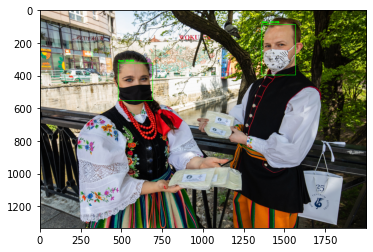

In [9]:
plt.imshow(image)